In [ ]:
# ============================================================================
# Deep Q-Learning Implementation for VideoPinball Environment
# Assignment: LLM Agents & Deep Q-Learning with Atari Games
# Environment: ALE/Video Pinball-v5
# Framework: PyTorch (instead of Keras)
# ============================================================================

# Cell 1: Install Required Packages
"""
Run this cell first to install all dependencies
"""
!pip install gymnasium
!pip install "gymnasium[atari]"
!pip install "gymnasium[accept-rom-license]"
!pip install ale-py
!pip install torch torchvision
!pip install opencv-python
!pip install imageio
!pip install imageio-ffmpeg
!pip install tqdm
!pip install matplotlib

print("\n✅ All packages installed successfully!")
print("Checking PyTorch installation...")

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✅ All packages installed successfully!
Checking PyTorch installation...
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [ ]:
# Cell 2: Import Libraries and Setup
# ============================================================================

import gymnasium as gym
import numpy as np
import torch
import gc
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
from tqdm import trange
import matplotlib.pyplot as plt
import cv2
from IPython.display import HTML, display
import imageio
import base64
import ale_py

# Register ALE environments
gym.register_envs(ale_py)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Warning: CUDA not available, using CPU")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("\n✅ All libraries imported successfully!")
print("✅ Random seeds set for reproducibility")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB

✅ All libraries imported successfully!
✅ Random seeds set for reproducibility


In [ ]:
# Cell 2.5: Frame Skipping Wrapper (FIXED WITH MAX-POOLING)
# ============================================================================
class FrameSkip(gym.Wrapper):
    """
    Skip frames and return max over last observations.
    CRITICAL for Atari games to handle flickering.
    """
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip
        # Buffer to store the last two observations for max-pooling
        self._obs_buffer = deque(maxlen=2)

    def step(self, action):
        total_reward = 0.0
        terminated = truncated = False

        for i in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs) # Store the observation
            total_reward += reward

            if terminated or truncated:
                break

        # If the buffer is full (i.e., we have 2 frames),
        # take the element-wise maximum over them
        if len(self._obs_buffer) == 2:
            max_frame = np.maximum(self._obs_buffer[0], self._obs_buffer[1])
        else:
            # Buffer only has one frame (e.g., at the very start)
            max_frame = self._obs_buffer[0]

        return max_frame, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        """Reset the environment and clear the buffer."""
        self._obs_buffer.clear()
        return self.env.reset(**kwargs)

print("=" * 60)
print("FRAME SKIPPING WRAPPER (WITH MAX-POOLING)")
print("=" * 60)
print("✅ Frame skip wrapper (Cell 2.5) now performs max-pooling.")
print("  This is CRITICAL for Atari to prevent flickering objects")
print("  from making the environment non-deterministic.")
print("=" * 60)

FRAME SKIPPING WRAPPER (WITH MAX-POOLING)
✅ Frame skip wrapper (Cell 2.5) now performs max-pooling.
  This is CRITICAL for Atari to prevent flickering objects
  from making the environment non-deterministic.


In [ ]:
# Cell 3: Hyperparameters Configuration
# ============================================================================


BUFFER_CAPACITY = 100_000
GAMMA = 0.99
LR = 0.00025
ALPHA = 0.95
BATCH_SIZE = 32

# EXPLORATION & LEARNING TIMING
EPSILON_START = 1.0
EPSILON_FINAL = 0.1
EPSILON_DECAY_STEPS = 10_000
NUM_EPISODES = 5000               # Start with 1000
TARGET_UPDATE_FREQ = 1000

# CRITICAL: Start learning after filling buffer
LEARNING_STARTS = 5_000
USE_UNIFORM_EXPLORATION = True
GRADIENT_CLIP = 1.0

print("=" * 60)
print("VIDEO PINBALL")
print("=" * 60)
print(f"Episodes:               {NUM_EPISODES}")
print(f"Epsilon Decay Steps:    {EPSILON_DECAY_STEPS:,}")
print(f"Learning Starts:        {LEARNING_STARTS:,}")
print(f"Target Update Freq:     {TARGET_UPDATE_FREQ:,}")
print("=" * 60)
print("\n🎯 STRATEGY:")
print("=" * 60)


VIDEO PINBALL
Episodes:               5000
Epsilon Decay Steps:    10,000
Learning Starts:        5,000
Target Update Freq:     1,000

🎯 STRATEGY:


In [ ]:
# Cell 4: DQN Network Architecture
# ============================================================================
class DQN(nn.Module):
    """
    Improved DQN with dueling architecture

    """
    def __init__(self, num_actions):
        super(DQN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Fully connected layer
        self.fc1 = nn.Linear(3136, 512) # 3136 = 64 * 7 * 7

        # Dueling DQN architecture
        self.value_stream = nn.Linear(512, 1)
        self.advantage_stream = nn.Linear(512, num_actions)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Better weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Normalize input
        x = x / 255.0

        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # Fully connected
        x = F.relu(self.fc1(x))

        # Dueling DQN: V(s) + A(s,a) - mean(A(s,a))
        value = self.value_stream(x)
        advantages = self.advantage_stream(x)

        # Combine value and advantage streams
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))

        return q_values

# Test the network
print("=" * 60)
print("DQN ARCHITECTURE")
print("=" * 60)

# Create a test environment to get action space size
import ale_py
gym.register_envs(ale_py)

test_env = gym.make("ALE/VideoPinball-v5")  # ⬅️ VIDEO PINBALL
num_actions = test_env.action_space.n
print(f"Number of actions for Video Pinball: {num_actions}")

# Create test network
test_net = DQN(num_actions).to(device)
print(f"\nNetwork created and moved to: {device}")

# Test with dummy input
dummy_input = torch.randn(1, 4, 84, 84).to(device)
dummy_output = test_net(dummy_input)
print(f"\nTest forward pass:")
print(f"  Input shape:  {dummy_input.shape}")
print(f"  Output shape: {dummy_output.shape}")

# Count parameters
total_params = sum(p.numel() for p in test_net.parameters())
trainable_params = sum(p.numel() for p in test_net.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\n" + "=" * 60)
print("✅ DQN Network")
print("=" * 60)

test_env.close()


DQN ARCHITECTURE
Number of actions for Video Pinball: 9

Network created and moved to: cuda

Test forward pass:
  Input shape:  torch.Size([1, 4, 84, 84])
  Output shape: torch.Size([1, 9])

Total parameters: 1,689,258
Trainable parameters: 1,689,258

✅ DQN Network


In [ ]:
# Cell 5: Replay Buffer Implementation
# ============================================================================
class ReplayBuffer:
    """
    Experience Replay Buffer for DQN

    """
    def __init__(self, capacity, obs_shape, device="cuda"):
        self.capacity = capacity
        self.device = device
        self.idx = 0
        self.full = False

        # Preallocate tensors on GPU
        self.states = torch.zeros((capacity, *obs_shape), dtype=torch.uint8, device=device)
        self.next_states = torch.zeros((capacity, *obs_shape), dtype=torch.uint8, device=device)
        self.actions = torch.zeros((capacity,), dtype=torch.long, device=device)
        self.rewards = torch.zeros((capacity,), dtype=torch.float32, device=device)
        self.dones = torch.zeros((capacity,), dtype=torch.float32, device=device)

    def push(self, state, action, reward, next_state, done):
        """Add a transition to the buffer"""
        self.states[self.idx] = torch.tensor(state, dtype=torch.uint8, device=self.device)
        self.next_states[self.idx] = torch.tensor(next_state, dtype=torch.uint8, device=self.device)
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.dones[self.idx] = float(done)

        self.idx = (self.idx + 1) % self.capacity
        if self.idx == 0:
            self.full = True

    def sample(self, batch_size):
        """Sample a random batch of transitions"""
        max_idx = self.capacity if self.full else self.idx
        idxs = torch.randint(0, max_idx, (batch_size,), device=self.device)

        return (
            self.states[idxs].to(torch.float32),
            self.actions[idxs],
            self.rewards[idxs],
            self.next_states[idxs].to(torch.float32),
            self.dones[idxs],
        )

    def __len__(self):
        """Return current size of buffer"""
        return self.capacity if self.full else self.idx

print("=" * 60)
print("REPLAY BUFFER ")
print("=" * 60)
print("✅ Replay Buffer implemented")
print("=" * 60)

REPLAY BUFFER 
✅ Replay Buffer implemented


In [ ]:
# Cell 6: Action Selection with TRUE Uniform Exploration
# ============================================================================
# Global counter for round-robin action selection
uniform_action_counter = 0

def get_action(policy_net, state, epsilon, env, global_step=None, num_actions=None):
    """
    Select action using epsilon-greedy with uniform exploration
    """
    global uniform_action_counter

    # UNIFORM EXPLORATION: Use each action in sequence, cycling through all
    if USE_UNIFORM_EXPLORATION and global_step is not None and global_step < LEARNING_STARTS:
        action = uniform_action_counter % num_actions
        uniform_action_counter += 1
        return action

    # Normal epsilon-greedy after exploration
    if random.random() < epsilon:
        return env.action_space.sample()

    # Exploitation
    with torch.no_grad():
        state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
        q_values = policy_net(state_tensor)
        return q_values.argmax(dim=1).item()

print("=" * 60)
print("ACTION SELECTION ")
print("=" * 60)
print("✅ TRUE Uniform exploration - cycles through ALL actions")
print("✅ Counter persists across episode resets")
print("=" * 60)

ACTION SELECTION 
✅ TRUE Uniform exploration - cycles through ALL actions
✅ Counter persists across episode resets


In [ ]:
# Cell 7: Training Function
# ============================================================================
def train(env, policy_net, target_net, replay_buffer, optimizer, loss_fn):
    """
    Training with TRUE uniform exploration

    """
    global uniform_action_counter
    uniform_action_counter = 0  # Reset counter at start

    rewards, losses = [], []
    global_step = 0
    action_counts_exploration = [0] * env.action_space.n
    num_actions = env.action_space.n

    def get_epsilon(step):
        if step < LEARNING_STARTS:
            return 1.0
        elif step < EPSILON_DECAY_STEPS:
            fraction = (step - LEARNING_STARTS) / (EPSILON_DECAY_STEPS - LEARNING_STARTS)
            return EPSILON_START - fraction * (EPSILON_START - EPSILON_FINAL)
        else:
            return EPSILON_FINAL

    pbar = trange(NUM_EPISODES, desc="Training", unit="ep")

    for episode in pbar:
        state, _ = env.reset()
        state = np.array(state)
        total_reward, done = 0, False
        episode_losses = []
        episode_steps = 0

        while not done:
            episode_steps += 1
            epsilon = get_epsilon(global_step)

            # Select action with global_step for uniform exploration
            action = get_action(policy_net, state, epsilon, env,
                              global_step=global_step, num_actions=num_actions)

            # Track actions during exploration
            if global_step < LEARNING_STARTS:
                action_counts_exploration[action] += 1

            global_step += 1

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state)
            done = terminated or truncated

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Train only after exploration
            if global_step >= LEARNING_STARTS and len(replay_buffer) >= BATCH_SIZE:
                states, actions, rewards_b, next_states, dones = replay_buffer.sample(BATCH_SIZE)

                with torch.no_grad():
                    next_actions = policy_net(next_states).argmax(1)
                    next_q = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    target_q = rewards_b + GAMMA * next_q * (1 - dones)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                loss = F.smooth_l1_loss(q_values, target_q)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), GRADIENT_CLIP)
                optimizer.step()

                episode_losses.append(loss.item())

                if global_step % TARGET_UPDATE_FREQ == 0:
                    target_net.load_state_dict(policy_net.state_dict())

            # Show exploration completion
            if global_step == LEARNING_STARTS:
                print("\n" + "=" * 60)
                print("🎉 UNIFORM EXPLORATION COMPLETE!")
                print("=" * 60)

                # Get action meanings from environment
                unwrapped = env
                while hasattr(unwrapped, 'env'):
                    unwrapped = unwrapped.env
                try:
                    action_meanings = unwrapped.unwrapped.get_action_meanings()
                except:
                    action_meanings = [f"ACTION_{i}" for i in range(num_actions)]

                print("Action distribution during exploration:")
                total_exp = sum(action_counts_exploration)
                expected_per_action = total_exp / num_actions

                for i, count in enumerate(action_counts_exploration):
                    pct = (count / total_exp * 100) if total_exp > 0 else 0
                    expected_pct = 100.0 / num_actions
                    diff = pct - expected_pct
                    action_name = action_meanings[i] if i < len(action_meanings) else f"ACTION_{i}"
                    print(f"  {action_name:<20} {count:>4} ({pct:>5.1f}%) [Expected: {expected_pct:.1f}%, Diff: {diff:+.1f}%]")
                print("=" * 60)
                print("Now starting learning phase...")
                print("=" * 60 + "\n")

        rewards.append(total_reward)
        if episode_losses:
            losses.append(np.mean(episode_losses))

        avg_reward = np.mean(rewards)
        avg_loss = np.mean(losses) if losses else 0
        status = "UNIFORM_EXPLORE" if global_step < LEARNING_STARTS else "LEARNING"

        pbar.set_postfix({
            "Status": status,
            "R": f"{total_reward:.0f}",
            "Avg": f"{avg_reward:.0f}",
            "Loss": f"{avg_loss:.3f}",
            "Eps": f"{epsilon:.2f}",
            "Step": global_step
        })

    return rewards, losses

print("=" * 60)
print("TRAINING FUNCTION")
print("=" * 60)
print("✅ Guarantees uniform action exploration")
print("=" * 60)

TRAINING FUNCTION
✅ Guarantees uniform action exploration


In [ ]:
# Cell 7.5: Episodic Life Wrapper (WITH PENALTY)
# ============================================================================

class EpisodicLifeWrapper(gym.Wrapper):
    """
    Treats a life loss as the end of an episode AND applies a large
    negative penalty.
    """
    def __init__(self, env):
        super().__init__(env)
        self.current_lives = 0
        self.life_was_lost = False
        self.crash_penalty = -100.0

    def reset(self, **kwargs):
        """Reset the environment and the life counter."""
        self.life_was_lost = False
        obs, info = self.env.reset(**kwargs)
        self.current_lives = self.env.unwrapped.ale.lives()
        return obs, info

    def step(self, action):
        """
        Step the environment and check for life loss.
        If a life is lost, set terminated=True and apply the penalty.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Get new life count
        new_lives = self.env.unwrapped.ale.lives()

        self.life_was_lost = new_lives < self.current_lives
        self.current_lives = new_lives

        # If a life was lost OR the game ended
        if self.life_was_lost or terminated:
            terminated = True
            # CRITICAL: Apply death penalty
            reward = self.crash_penalty

        return obs, reward, terminated, truncated, info

print("=" * 60)
print("EPISODIC LIFE WRAPPER ")
print("=" * 60)
print("✅ Death penalty: -100.0 ")
print("=" * 60)

EPISODIC LIFE WRAPPER 
✅ Death penalty: -100.0 


In [ ]:
# Cell 8: Setup Environment and Networks
# ============================================================================
print("=" * 60)
print("ENVIRONMENT SETUP - VIDEO PINBALL")
print("=" * 60)

# Create and wrap the environment
print("\n1. Creating Video Pinball environment...")
env = gym.make("ALE/VideoPinball-v5", render_mode="rgb_array")  #

# Apply wrappers i
env = EpisodicLifeWrapper(env)
print("   ✅ EpisodicLifeWrapper applied (terminates on life loss)")

env = FrameSkip(env, skip=4)
print("   ✅ FrameSkip wrapper applied (skip=4)")

env = gym.wrappers.RecordEpisodeStatistics(env)
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayscaleObservation(env)
env = gym.wrappers.FrameStackObservation(env, 4)
print("   ✅ Resize, Grayscale, and FrameStack wrappers applied")
print("   ✅ RecordEpisodeStatistics wrapper applied")

# Get observation and action space info
obs_shape = env.observation_space.shape
num_actions = env.action_space.n
print(f"\n2. Environment details:")
print(f"   - Observation shape: {obs_shape}")
print(f"   - Number of actions: {num_actions}")

# Create networks
print("\n3. Initializing networks...")
policy_net = DQN(num_actions)
target_net = DQN(num_actions)
print("   ✅ Policy network created")
print("   ✅ Target network created")

# Move to GPU if available
policy_net = policy_net.to(device)
target_net = target_net.to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
print(f"   ✅ Networks moved to {device}")
print("   ✅ Target network weights synchronized")

# Create optimizer - RMSprop
print("\n4. Initializing optimizer and loss...")
optimizer = torch.optim.RMSprop(
    policy_net.parameters(),
    lr=LR,
    alpha=ALPHA,
    eps=1e-08,
    centered=True
)
print(f"   ✅ RMSprop optimizer created (lr={LR}, alpha={ALPHA})")
print("   ✅ Using Smooth L1 Loss (Huber Loss)")

# Create replay buffer
print("\n5. Creating replay buffer...")
replay_buffer = ReplayBuffer(BUFFER_CAPACITY, obs_shape, device=device)
print(f"   ✅ Replay buffer created (capacity: {BUFFER_CAPACITY:,})")

# Summary
print("\n" + "=" * 60)
print("SETUP COMPLETE")
print("=" * 60)
print(f"Device: {device}")
print(f"Environment: Video Pinball")
print(f"Wrapper order: EpisodicLife -> FrameSkip -> Resize -> Gray -> Stack")
print("=" * 60)

ENVIRONMENT SETUP - VIDEO PINBALL

1. Creating Video Pinball environment...
   ✅ EpisodicLifeWrapper applied (terminates on life loss)
   ✅ FrameSkip wrapper applied (skip=4)
   ✅ Resize, Grayscale, and FrameStack wrappers applied
   ✅ RecordEpisodeStatistics wrapper applied

2. Environment details:
   - Observation shape: (4, 84, 84)
   - Number of actions: 9

3. Initializing networks...
   ✅ Policy network created
   ✅ Target network created
   ✅ Networks moved to cuda
   ✅ Target network weights synchronized

4. Initializing optimizer and loss...
   ✅ RMSprop optimizer created (lr=0.00025, alpha=0.95)
   ✅ Using Smooth L1 Loss (Huber Loss)

5. Creating replay buffer...
   ✅ Replay buffer created (capacity: 100,000)

SETUP COMPLETE
Device: cuda
Environment: Video Pinball
Wrapper order: EpisodicLife -> FrameSkip -> Resize -> Gray -> Stack


In [ ]:
# Cell 9: Run Training
# ============================================================================
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)
print(f"Training for {NUM_EPISODES} episodes...")
print(f"Estimated time: ~60-90 minutes")
print("=" * 60)
print()

# Run training
rewards, losses = train(env, policy_net, target_net, replay_buffer, optimizer, loss_fn=None)

print()
print("=" * 60)
print("TRAINING COMPLETED!")
print("=" * 60)
print(f"Total episodes: {len(rewards)}")
if rewards:
    print(f"Average reward: {np.mean(rewards):.2f}")
    print(f"Max reward: {max(rewards):.2f}")
    print(f"Min reward: {min(rewards):.2f}")
if losses:
    print(f"Average loss: {np.mean(losses):.4f}")
print("=" * 60)

STARTING TRAINING
Training for 5000 episodes...
Estimated time: ~60-90 minutes



Training:   1%|          | 43/5000 [00:23<49:36,  1.67ep/s, Status=UNIFORM_EXPLORE, R=1200, Avg=2885, Loss=0.000, Eps=1.00, Step=4982]  


🎉 UNIFORM EXPLORATION COMPLETE!
Action distribution during exploration:
  NOOP                  556 ( 11.1%) [Expected: 11.1%, Diff: +0.0%]
  FIRE                  556 ( 11.1%) [Expected: 11.1%, Diff: +0.0%]
  UP                    556 ( 11.1%) [Expected: 11.1%, Diff: +0.0%]
  RIGHT                 556 ( 11.1%) [Expected: 11.1%, Diff: +0.0%]
  LEFT                  556 ( 11.1%) [Expected: 11.1%, Diff: +0.0%]
  DOWN                  555 ( 11.1%) [Expected: 11.1%, Diff: -0.0%]
  UPFIRE                555 ( 11.1%) [Expected: 11.1%, Diff: -0.0%]
  RIGHTFIRE             555 ( 11.1%) [Expected: 11.1%, Diff: -0.0%]
  LEFTFIRE              555 ( 11.1%) [Expected: 11.1%, Diff: -0.0%]
Now starting learning phase...



Training: 100%|█████████▉| 4997/5000 [1:37:42<00:05,  1.73s/ep, Status=LEARNING, R=2406, Avg=2137, Loss=44.346, Eps=0.10, Step=630226]

TRAINING VISUALIZATION


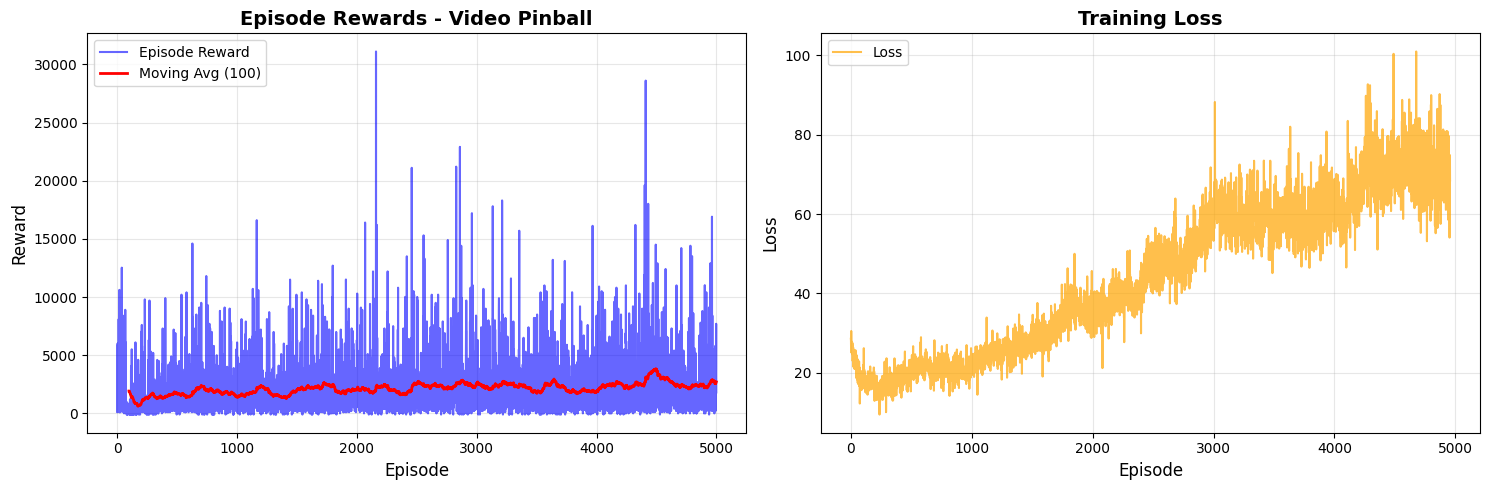


Detailed Statistics:
------------------------------------------------------------
Total Episodes:        5000
Average Reward:        2138.58
Std Dev Reward:        2474.22
Max Reward:            31108.00
Min Reward:            -100.00
Median Reward:         1400.00

Average Loss:          44.3608
Final Loss:            68.4588
------------------------------------------------------------

✅ Training visualization complete!


In [ ]:
# Cell 10: Visualize Training Results
# ============================================================================
def plot_training_curves(rewards, losses, window=100):
    """
    Plot training rewards and losses

    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot rewards
    ax1.plot(rewards, label="Episode Reward", alpha=0.6, color='blue')
    if len(rewards) >= window:
        rewards_mavg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(rewards)), rewards_mavg,
                label=f"Moving Avg ({window})", color="red", linewidth=2)
    ax1.set_xlabel("Episode", fontsize=12)
    ax1.set_ylabel("Reward", fontsize=12)
    ax1.set_title("Episode Rewards - Video Pinball", fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot losses
    if losses:
        ax2.plot(losses, label="Loss", alpha=0.7, color='orange')
        ax2.set_xlabel("Episode", fontsize=12)
        ax2.set_ylabel("Loss", fontsize=12)
        ax2.set_title("Training Loss", fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No loss data available',
                ha='center', va='center', transform=ax2.transAxes)

    plt.tight_layout()
    plt.show()

print("=" * 60)
print("TRAINING VISUALIZATION")
print("=" * 60)

# Plot the results
plot_training_curves(rewards, losses, window=min(100, len(rewards)))

# Show detailed statistics
print("\nDetailed Statistics:")
print("-" * 60)
print(f"Total Episodes:        {len(rewards)}")
print(f"Average Reward:        {np.mean(rewards):.2f}")
print(f"Std Dev Reward:        {np.std(rewards):.2f}")
print(f"Max Reward:            {max(rewards):.2f}")
print(f"Min Reward:            {min(rewards):.2f}")
print(f"Median Reward:         {np.median(rewards):.2f}")
if losses:
    print(f"\nAverage Loss:          {np.mean(losses):.4f}")
    print(f"Final Loss:            {losses[-1]:.4f}")
print("-" * 60)

print("\n✅ Training visualization complete!")
print("=" * 60)

In [ ]:
# Cell 11: Test Agent
# ============================================================================

policy_net.eval()
test_rewards = []
test_actions = {}

print("=" * 60)
print("TESTING TRAINED AGENT (10 episodes)")
print("=" * 60)

for ep in range(10):
    state, _ = env.reset()
    state = np.array(state)
    done = False
    total_reward = 0
    steps = 0

    while not done and steps < 5000:
        with torch.no_grad():
            s = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
            action = policy_net(s).argmax(1).item()
        test_actions[action] = test_actions.get(action, 0) + 1
        state, reward, terminated, truncated, _ = env.step(action)
        state = np.array(state)
        done = terminated or truncated
        total_reward += reward
        steps += 1

    test_rewards.append(total_reward)
    print(f"Ep {ep+1}: {total_reward:.0f} ({steps} steps)")

print(f"\nTest avg: {np.mean(test_rewards):.0f}")
print(f"Actions used: {len(test_actions)}/{num_actions}")

# Show action distribution
print("\nAction usage during testing:")
try:
    unwrapped = env
    while hasattr(unwrapped, 'env'):
        unwrapped = unwrapped.env
    action_meanings = unwrapped.unwrapped.get_action_meanings()

    total_test = sum(test_actions.values())
    for action in sorted(test_actions.keys()):
        name = action_meanings[action]
        count = test_actions[action]
        pct = count/total_test*100
        print(f"  {name:<15}: {count:5d} ({pct:5.1f}%)")
except:
    for action, count in test_actions.items():
        print(f"  Action {action}: {count}")

print("=" * 60)

env.close()

TESTING TRAINED AGENT (10 episodes)
Ep 1: 200 (64 steps)
Ep 2: 300 (40 steps)
Ep 3: 1600 (96 steps)
Ep 4: 1000 (41 steps)
Ep 5: 200 (64 steps)
Ep 6: 1000 (41 steps)
Ep 7: 4402 (80 steps)
Ep 8: 1600 (96 steps)
Ep 9: 1000 (41 steps)
Ep 10: 2002 (46 steps)

Test avg: 1330
Actions used: 9/9

Action usage during testing:
  NOOP           :    16 (  2.6%)
  FIRE           :   282 ( 46.3%)
  UP             :    67 ( 11.0%)
  RIGHT          :    32 (  5.3%)
  LEFT           :    86 ( 14.1%)
  DOWN           :    21 (  3.4%)
  UPFIRE         :    31 (  5.1%)
  RIGHTFIRE      :    35 (  5.7%)
  LEFTFIRE       :    39 (  6.4%)


In [ ]:
# Cell 12: Diagnostic - Action Distribution
# ============================================================================
print("=" * 60)
print("DIAGNOSTIC: ACTION DISTRIBUTION")
print("=" * 60)

def analyze_actions(env, policy_net, num_steps=500):
    """Analyze actions with network in eval mode"""
    policy_net.eval()

    state, _ = env.reset()
    state = np.array(state)

    action_counts = [0] * env.action_space.n
    q_values_list = []

    for step in range(num_steps):
        with torch.no_grad():
            state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
            q_values = policy_net(state_tensor)
            action = q_values.argmax(dim=1).item()
            q_values_list.append(q_values.cpu().numpy()[0])

        action_counts[action] += 1

        next_state, reward, terminated, truncated, _ = env.step(action)
        state = np.array(next_state)

        if terminated or truncated:
            state, _ = env.reset()
            state = np.array(state)

    policy_net.train()
    return action_counts, q_values_list

# Recreate env for testing
env = gym.make("ALE/VideoPinball-v5", render_mode="rgb_array")
env = EpisodicLifeWrapper(env)
env = FrameSkip(env, skip=4)
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayscaleObservation(env)
env = gym.wrappers.FrameStackObservation(env, 4)

# Get action meanings
unwrapped_env = env
while hasattr(unwrapped_env, 'env'):
    unwrapped_env = unwrapped_env.env

try:
    ACTION_MEANINGS = unwrapped_env.unwrapped.get_action_meanings()
    print(f"✅ Got {len(ACTION_MEANINGS)} action meanings: {ACTION_MEANINGS}")
except:
    ACTION_MEANINGS = [f"ACTION_{i}" for i in range(env.action_space.n)]
    print(f"⚠️  Using generic action names")

print("\nAnalyzing 500 steps...")
action_counts, q_values_list = analyze_actions(env, policy_net, num_steps=500)

# Display
print("\n" + "=" * 60)
print("ACTION DISTRIBUTION (500 steps)")
print("=" * 60)

total_actions = sum(action_counts)
for i, count in enumerate(action_counts):
    action_name = ACTION_MEANINGS[i] if i < len(ACTION_MEANINGS) else f"ACTION_{i}"
    percentage = (count / total_actions * 100) if total_actions > 0 else 0
    bar = "█" * int(percentage / 2)
    print(f"{action_name:<20} {count:<10} {percentage:>5.1f}% {bar}")

print("=" * 60)

# Q-values
q_values_array = np.array(q_values_list)
print("\n" + "=" * 60)
print("Q-VALUE STATISTICS")
print("=" * 60)
print(f"Mean: {q_values_array.mean():.4f}, Std: {q_values_array.std():.4f}")
print(f"Max: {q_values_array.max():.4f}, Min: {q_values_array.min():.4f}")

if abs(q_values_array.mean()) < 10:
    print("\n⚠️  Q-values low - may need more training")
else:
    print("\n✅ Q-values indicate learning")
print("=" * 60)

env.close()

DIAGNOSTIC: ACTION DISTRIBUTION
✅ Got 9 action meanings: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE']

Analyzing 500 steps...

ACTION DISTRIBUTION (500 steps)
NOOP                 1            0.2% 
FIRE                 191         38.2% ███████████████████
UP                   34           6.8% ███
RIGHT                14           2.8% █
LEFT                 165         33.0% ████████████████
DOWN                 17           3.4% █
UPFIRE               41           8.2% ████
RIGHTFIRE            21           4.2% ██
LEFTFIRE             16           3.2% █

Q-VALUE STATISTICS
Mean: 1607.7258, Std: 1181.3575
Max: 5067.6001, Min: -350.5419

✅ Q-values indicate learning


In [ ]:
# Cell 11: Video Recording and Visualization Function
def record_agent_gameplay(env, policy_net, num_episodes=1, max_steps=1000):
    """
    Record the trained agent playing the game

    Args:
        env: The game environment
        policy_net: Trained policy network
        num_episodes: Number of episodes to record
        max_steps: Maximum steps per episode

    Returns:
        frames: List of frames for video creation
        episode_rewards: List of rewards per episode
    """
    all_frames = []
    episode_rewards = []

    policy_net.eval()  # Set to evaluation mode

    print(f"Recording {num_episodes} episode(s)...")

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = np.array(state)
        frames = []
        total_reward = 0
        done = False
        steps = 0

        while not done and steps < max_steps:
            # Render frame
            frame = env.render()
            frames.append(frame)

            # Select action (greedy, no exploration)
            with torch.no_grad():
                state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
                q_values = policy_net(state_tensor)
                action = q_values.argmax(dim=1).item()

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state)
            done = terminated or truncated

            state = next_state
            total_reward += reward
            steps += 1

        all_frames.extend(frames)
        episode_rewards.append(total_reward)
        print(f"  Episode {episode + 1}: Reward = {total_reward:.1f}, Steps = {steps}")

    return all_frames, episode_rewards

def create_video_html(frames, fps=30):
    """
    Create an HTML5 video from frames for display in Colab

    Args:
        frames: List of image frames
        fps: Frames per second

    Returns:
        HTML object for display
    """
    # Save frames as video
    video_path = "/content/video pinball_gameplay.mp4"
    imageio.mimsave(video_path, frames, fps=fps)

    # Read video and encode to base64
    with open(video_path, "rb") as f:
        video_data = f.read()
    video_base64 = base64.b64encode(video_data).decode()

    # Create HTML
    html = f"""
    <video width="400" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    return HTML(html)

print("=" * 60)
print("VIDEO RECORDING FUNCTIONS")
print("=" * 60)
print("✓ Video recording function defined")
print("✓ HTML video creator defined")
print("\nThese functions will:")
print("  1. Record the agent playing Video pinball")
print("  2. Capture frames during gameplay")
print("  3. Create an MP4 video")
print("  4. Display it inline in the notebook")
print("=" * 60)

VIDEO RECORDING FUNCTIONS
✓ Video recording function defined
✓ HTML video creator defined

These functions will:
  1. Record the agent playing Video pinball
  2. Capture frames during gameplay
  3. Create an MP4 video
  4. Display it inline in the notebook


In [ ]:
# Cell 12: Record and Display Agent Gameplay
print("=" * 60)
print("RECORDING AGENT GAMEPLAY")
print("=" * 60)

# Record gameplay
print("\nRecording agent playing Video pinball...")
print("(Using greedy policy - no exploration)")
print()
frames, episode_rewards = record_agent_gameplay(
    env,
    policy_net,
    num_episodes=1,  # Record 1 episode
    max_steps=2000    # Maximum 500 steps
)

print()
print("=" * 60)
print("RECORDING COMPLETE")
print("=" * 60)
print(f"Total frames captured: {len(frames)}")
print(f"Episode reward: {episode_rewards[0]:.1f}")
print("=" * 60)

# Create and display video
print("\nCreating video...")
video_html = create_video_html(frames, fps=30)

print("✓ Video created successfully!")
print("\nDisplaying gameplay video:")
print("-" * 60)

display(video_html)

print("-" * 60)
print("✓ Video displayed above")
print("\nYou can:")
print("  • Play/pause the video")
print("  • See the agent's learned behavior")
print("  • Download the video (right-click)")
print(f"  • Video saved at: /content/video_pinball_gameplay.mp4")
print("=" * 60)

RECORDING AGENT GAMEPLAY

Recording agent playing Video pinball...
(Using greedy policy - no exploration)

Recording 1 episode(s)...
  Episode 1: Reward = 6004.0, Steps = 136

RECORDING COMPLETE
Total frames captured: 136
Episode reward: 6004.0

Creating video...


✓ Video created successfully!

Displaying gameplay video:
------------------------------------------------------------


------------------------------------------------------------
✓ Video displayed above

You can:
  • Play/pause the video
  • See the agent's learned behavior
  • Download the video (right-click)
  • Video saved at: /content/video_pinball_gameplay.mp4


In [ ]:
# Cell 13: Diagnostic - Compare Random vs Trained Agent
print("=" * 60)
print("DIAGNOSTIC: RANDOM vs TRAINED AGENT")
print("=" * 60)

def test_agent(env, policy_net=None, num_episodes=5, use_random=False):
    """
    Test agent and return statistics

    Args:
        env: Environment
        policy_net: Policy network (None for random)
        num_episodes: Number of test episodes
        use_random: If True, use random actions
    """
    rewards = []
    steps_list = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = np.array(state)
        total_reward = 0
        done = False
        steps = 0

        while not done and steps < 1000:
            if use_random:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax(dim=1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state)
            done = terminated or truncated

            state = next_state
            total_reward += reward
            steps += 1

        rewards.append(total_reward)
        steps_list.append(steps)
        print(f"  Episode {episode + 1}: Reward = {total_reward:.1f}, Steps = {steps}")

    return rewards, steps_list

# Test Random Agent
print("\n1. Testing RANDOM Agent (5 episodes):")
print("-" * 60)
random_rewards, random_steps = test_agent(env, use_random=True, num_episodes=5)

# Test Trained Agent
print("\n2. Testing TRAINED Agent (5 episodes):")
print("-" * 60)
trained_rewards, trained_steps = test_agent(env, policy_net=policy_net, use_random=False, num_episodes=5)

# Compare Results
print("\n" + "=" * 60)
print("COMPARISON RESULTS")
print("=" * 60)
print(f"{'Metric':<25} {'Random':<15} {'Trained':<15} {'Difference'}")
print("-" * 60)
print(f"{'Average Reward':<25} {np.mean(random_rewards):<15.2f} {np.mean(trained_rewards):<15.2f} {np.mean(trained_rewards) - np.mean(random_rewards):.2f}")
print(f"{'Max Reward':<25} {max(random_rewards):<15.2f} {max(trained_rewards):<15.2f} {max(trained_rewards) - max(random_rewards):.2f}")
print(f"{'Min Reward':<25} {min(random_rewards):<15.2f} {min(trained_rewards):<15.2f} {min(trained_rewards) - min(random_rewards):.2f}")
print(f"{'Average Steps':<25} {np.mean(random_steps):<15.2f} {np.mean(trained_steps):<15.2f} {np.mean(trained_steps) - np.mean(random_steps):.2f}")
print("=" * 60)

if np.mean(trained_rewards) < np.mean(random_rewards):
    print("\n⚠️  WARNING: Trained agent is WORSE than random!")
    print("   This indicates a serious training issue.")
elif np.mean(trained_rewards) < np.mean(random_rewards) * 1.5:
    print("\n⚠️  WARNING: Trained agent barely better than random!")
    print("   Learning is happening but very slowly.")
else:
    print("\n✓ Trained agent is performing better than random!")

DIAGNOSTIC: RANDOM vs TRAINED AGENT

1. Testing RANDOM Agent (5 episodes):
------------------------------------------------------------
  Episode 1: Reward = 501.0, Steps = 52
  Episode 2: Reward = 3905.0, Steps = 121
  Episode 3: Reward = 1304.0, Steps = 150
  Episode 4: Reward = 5404.0, Steps = 176
  Episode 5: Reward = 1701.0, Steps = 154

2. Testing TRAINED Agent (5 episodes):
------------------------------------------------------------
  Episode 1: Reward = 10504.0, Steps = 256
  Episode 2: Reward = 11816.0, Steps = 293
  Episode 3: Reward = 200.0, Steps = 64
  Episode 4: Reward = 11509.0, Steps = 192
  Episode 5: Reward = 500.0, Steps = 103

COMPARISON RESULTS
Metric                    Random          Trained         Difference
------------------------------------------------------------
Average Reward            2563.00         6905.80         4342.80
Max Reward                5404.00         11816.00        6412.00
Min Reward                501.00          200.00          -301.

In [ ]:
import numpy as np
import torch
import imageio
import base64
from IPython.display import HTML, display
import gymnasium as gym

# --- NOTE: We are NOT importing or using the FrameSkip wrapper ---

print("=" * 60)
print("RUNNING 1 FULL GAME (3 LIVES) - 'NORMAL' ENV (NO SKIP)")
print("=" * 60)

# 1. Create a "Normal" test environment (NO FrameSkip)
print("Creating new 'normal' test environment (no frame skipping)...")
normal_test_env = gym.make("ALE/VideoPinball-v5", render_mode="rgb_array")
# We still need the other wrappers to match the agent's "vision"
normal_test_env = gym.wrappers.ResizeObservation(normal_test_env, (84, 84))
normal_test_env = gym.wrappers.GrayscaleObservation(normal_test_env)
normal_test_env = gym.wrappers.FrameStackObservation(normal_test_env, 4)
print("✓ Test environment created.")


# 2. Run the episode
frames = []
episode_reward = 0
max_steps_per_game = 5000

policy_net.eval()  # Set to evaluation mode
print("Recording 1 full game...")

state, _ = normal_test_env.reset()
state = np.array(state)
done = False
steps = 0

while not done and steps < max_steps_per_game:
    # Render frame
    frame = normal_test_env.render()
    frames.append(frame)

    # Select action (greedy, no exploration)
    with torch.no_grad():
        state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
        q_values = policy_net(state_tensor)
        action = q_values.argmax(dim=1).item()

    # Take action
    next_state, reward, terminated, truncated, _ = normal_test_env.step(action)
    next_state = np.array(next_state)
    done = terminated or truncated

    state = next_state
    episode_reward += reward
    steps += 1

print(f"  Game complete: Final Reward = {episode_reward:.1f}, Steps = {steps}")
print("=" * 60)

# 3. Create and display the video
print("Creating video... (at 60 fps for normal speed)")
video_path = "./video pinball_full_game_normal_env.mp4"

try:
    # --- Save at 60 fps to match the environment's true speed ---
    imageio.mimsave(video_path, frames, fps=60)

    # Read video and encode to base64
    with open(video_path, "rb") as f:
        video_data = f.read()
    video_base64 = base64.b64encode(video_data).decode()

    # Create HTML
    html_str = f"""
    <video width="400" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    print("✓ Video created successfully!")
    print("\nDisplaying full game video (normal environment):")
    print("-" * 60)
    display(HTML(html_str))
    print("-" * 60)

except Exception as e:
    print(f"ERROR: Could not create video. {e}")

# Clean up the test environment
normal_test_env.close()

RUNNING 1 FULL GAME (3 LIVES) - 'NORMAL' ENV (NO SKIP)
Creating new 'normal' test environment (no frame skipping)...
✓ Test environment created.
Recording 1 full game...


  Game complete: Final Reward = 3802.0, Steps = 5000
Creating video... (at 60 fps for normal speed)
✓ Video created successfully!

Displaying full game video (normal environment):
------------------------------------------------------------


------------------------------------------------------------


EVALUATION WITH VIDEO: FULL EPISODE WITH ALL 3 LIVES

Starting with 3 lives
----------------------------------------
  Step 100: Total reward = 8103, Lives remaining = 3
Life 1 lost: 8104 points in 116 steps
Life 2 lost: 1605 points in 67 steps
  Step 200: Total reward = 9910, Lives remaining = 1
Life 3 lost: 403 points in 34 steps
----------------------------------------

EPISODE COMPLETE!
Total Score: 10112
Total Steps: 217
Lives Used: 3/3
Average Score per Life: 3371
Best Life Score: 8104
Average Steps per Life: 72

----------------------------------------
ACTION PREFERENCE ANALYSIS (100 samples):
Top 5 preferred actions:
  DOWN                : 100%

----------------------------------------
Creating video from ALL 217 frames...


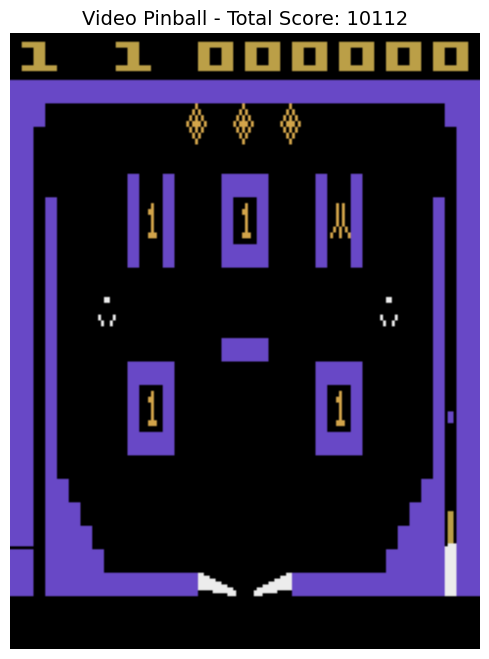

In [ ]:
# Cell: Evaluate Trained Model with Video - Full Episode with All Lives
print("=" * 60)
print("EVALUATION WITH VIDEO: FULL EPISODE WITH ALL 3 LIVES")
print("=" * 60)

from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib import animation

# Create environment for evaluation (NO EpisodicLife wrapper)
eval_env = gym.make("ALE/VideoPinball-v5", render_mode="rgb_array")
eval_env = FrameSkip(eval_env, skip=4)  # Keep frame skipping
eval_env = gym.wrappers.ResizeObservation(eval_env, (84, 84))
eval_env = gym.wrappers.GrayscaleObservation(eval_env)
eval_env = gym.wrappers.FrameStackObservation(eval_env, 4)

# Set network to evaluation mode
policy_net.eval()

# Lists to store frames for video
frames = []

# Run one complete episode
state, _ = eval_env.reset()
state = np.array(state)

total_reward = 0
episode_steps = 0
lives_lost = 0
initial_lives = eval_env.unwrapped.ale.lives()
current_lives = initial_lives

print(f"\nStarting with {initial_lives} lives")
print("-" * 40)

# Lists to track performance per life
life_rewards = []
life_steps = []
current_life_reward = 0
current_life_steps = 0

done = False
while not done:
    # Select action (no exploration - pure exploitation)
    with torch.no_grad():
        state_tensor = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
        q_values = policy_net(state_tensor)
        action = q_values.argmax(dim=1).item()

    # Take action
    next_state, reward, terminated, truncated, _ = eval_env.step(action)
    next_state = np.array(next_state)
    done = terminated or truncated

    # Capture EVERY frame for video
    base_env = eval_env
    while hasattr(base_env, 'env'):
        if hasattr(base_env, 'render'):
            break
        base_env = base_env.env
    frame = base_env.render()
    frames.append(frame)

    total_reward += reward
    episode_steps += 1
    current_life_reward += reward
    current_life_steps += 1

    # Check for life loss
    new_lives = eval_env.unwrapped.ale.lives()
    if new_lives < current_lives:
        lives_lost += 1
        life_rewards.append(current_life_reward)
        life_steps.append(current_life_steps)
        print(f"Life {lives_lost} lost: {current_life_reward:.0f} points in {current_life_steps} steps")
        current_lives = new_lives
        current_life_reward = 0
        current_life_steps = 0

    state = next_state

    # Display progress every 100 steps
    if episode_steps % 100 == 0:
        print(f"  Step {episode_steps}: Total reward = {total_reward:.0f}, Lives remaining = {current_lives}")

    # Safety limit to prevent infinite episodes
    if episode_steps > 10000:
        print("Episode exceeded 10000 steps, stopping...")
        break

# Final life (game over)
if current_life_steps > 0:
    life_rewards.append(current_life_reward)
    life_steps.append(current_life_steps)
    print(f"Final life: {current_life_reward:.0f} points in {current_life_steps} steps")

print("-" * 40)
print(f"\nEPISODE COMPLETE!")
print(f"Total Score: {total_reward:.0f}")
print(f"Total Steps: {episode_steps}")
print(f"Lives Used: {initial_lives - current_lives}/{initial_lives}")
if life_rewards:
    print(f"Average Score per Life: {np.mean(life_rewards):.0f}")
    print(f"Best Life Score: {max(life_rewards):.0f}")
    print(f"Average Steps per Life: {np.mean(life_steps):.0f}")

# Get action distribution
action_counts = {}
test_state, _ = eval_env.reset()
test_state = np.array(test_state)

# Sample 100 different states to see action preferences
print("\n" + "-" * 40)
print("ACTION PREFERENCE ANALYSIS (100 samples):")
for _ in range(100):
    with torch.no_grad():
        state_tensor = torch.tensor(test_state, device=device, dtype=torch.float32).unsqueeze(0)
        q_values = policy_net(state_tensor)
        action = q_values.argmax(dim=1).item()
    action_counts[action] = action_counts.get(action, 0) + 1
    # Small perturbation to state for variety
    test_state = test_state + np.random.randn(*test_state.shape) * 0.01

# Show most preferred actions
sorted_actions = sorted(action_counts.items(), key=lambda x: x[1], reverse=True)
action_meanings = eval_env.unwrapped.get_action_meanings()
print("Top 5 preferred actions:")
for action, count in sorted_actions[:5]:
    action_name = action_meanings[action] if action < len(action_meanings) else f"ACTION_{action}"
    print(f"  {action_name:<20}: {count}%")

eval_env.close()

# Create video with ALL frames
print("\n" + "-" * 40)
print(f"Creating video from ALL {len(frames)} frames...")

# Downsample frames if there are too many (for display performance)
max_frames_for_display = 2000
if len(frames) > max_frames_for_display:
    print(f"Note: Downsampling from {len(frames)} to {max_frames_for_display} frames for display")
    skip = len(frames) // max_frames_for_display
    display_frames = frames[::skip]
else:
    display_frames = frames

fig = plt.figure(figsize=(8, 8))
plt.axis('off')
im = plt.imshow(display_frames[0])
plt.title(f'Video Pinball - Total Score: {total_reward:.0f}', fontsize=14)

def animate(i):
    im.set_data(display_frames[i])
    return [im]

anim = animation.FuncAnimation(
    fig,
    animate,
    frames=len(display_frames),
    interval=33,  # ~30 FPS for smooth playback
    blit=True
)